# Exploring UMAP on a complete graph  (aka. 1-skeleton of an n-simplex)

Towards [Experiment #2: Evaluate UMAP(+HDBSCAN) as a graph embedding(clustering) algorithm](https://github.com/acwooding/HighDimensionalClustering/wiki/Experiments-to-Try). All notation is as in that post. 

Starting with a simple extreme case to see what's going on. How does the $X \rightarrow U(X)$ step work when all points are equidistant to each other? 

**Starter question:** When everything is equally far apart, how does it pick $k$ neighbours when $n$ is bigger than $k$? I'm thinking about whether it breaks it down in a balanced way or not. How does it tear apart something it can't? What happens? An $n$-simplex lives in $n-1$ dimensions. Does it do what's expected when $k=n$ (assuming by taking $k$ neighbours I'm count myself as a neighbour)?

**Summary of Takeaways**:
* (With precomputed distances) UMAP uses sort + truncate to determine the $k$ nearest neighbours. This leads to a biased and hence extremely unbalanced selection of $k$-nearest neighbours and an extremely unbalanced graph for $U(X)$. This is definitely **NOT** the behaviour we want. Here are some other options:
    * With random sampling of the $k$ nearest neighbours this can be fixed and make $U(X)$ seem reasonable and balanced. This is likely the "right" way to select the $k$-nearest neighbours when there is a tie for the $k^{th}$ neighbour, assuming we want to stick to exactly $k$ neighbours (which seems like a practical assumption). 
    * Another option is to keep all of the neighbours from the tie. In the case of an $n$-simplex, then $U(X)$ is the $n$-complete graph. This likely adds too much computational complexity in the extreme cases (like this one) and keeps too much information as we're not doing anything to select only local information. This is probably reasonable and fine in cases with very few ties, but unreasonable when there are highly connected objects like an $n$-simplex in the data (where $k$ is smaller than $n$).
    * Another option is to only go up to the neighbour that we're sure about. In the case of an $n$-simplex, then $U(X)$ is a completely disconnected graph on $n$-nodes. This retains no connection information from a highly connected object, so is also likely not what we want in cases where there are a lot of ties for $k^{th}$ nearest neighbour. As with the previous case, this is likely ok and maybe even what we want when there are very few ties, but will be problematic when there exists an $n$-simplex where $n$ is bigger than $k$. 
* When dealing with equidistant points in a highly connected configuration, fuzzy union behaves closer to what we'd expect and want from it (maintaining the connections that are all equally important) whereas fuzzy intersection completely disconnects the $n$-simplex. Both are extremes of "all of this information is equal to me". One preserves it, one destroys it. In the case of the $n$-simplex, I'd want the conenction information to be preserved. 
* When $k=n-1$, $X \rightarrow U(X)$ is the identity, as expected (there's really no other choice). I'd expect, in theory, that $U(X)$ for any graph $X$ on $n$ nodes should give the same graph with different weights perhaps, as all other nodes are in the $k$-nearest neighbours. This doesn't quite bear out like this. See below.
* **Technical note:** the graph layout step $V(X) \rightarrow Y$ refuses to place and layout singletons in the `metric='precomputed'` code path. This means that the fuzzy intersection fails to embed all of the $n$-simplex and morally only embeds birdirectional edges coming from $U(X)$. With random sampling this means that there is some counting argument (that I'm not going to work out here) that means that we can work out exactly how many point and edges we'd expect to preserve here. Morally the number is based on how likely 2 points are to choose each other as neighbours. In other words, the bigger $n$ is relative to $k$, the fewer points (proportional to $n$) get embedded. In this case I'd prefer laying out the singletons to not embedding them at all. I'm not sure yet what UMAP does to lay out disconnected components (in the case with a precomputed metric and random initialization for the graph layout) and what the issue is with randomly placing the singletons, but I'm assuming there's a reason this is bad....need to find out more. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import hdbscan
import umap
import umap.plot
import scipy

import igraph as ig

from src import paths

sns.set()

Some helper functions to access $U(X)$ and $V(X)$

In [3]:
from src.custom.utils import get_graph_UX, get_VX_from_UX

Let $k$ be the number of neighbours and $n$ be the size of the $n$-simplex, $X$

In [4]:
k = 10
n = 20

Adjacency matrix $M$ of a complete graph $X$

In [5]:
M = np.ones((n, n)) - np.identity(n)

Some fixed parameters

In [6]:
random_state = 42
metric = 'precomputed'

In [7]:
G = get_graph_UX(M,
                 n_neighbors=k,
                 random_state=random_state,
                 metric=metric)

Take a look at the matrix:

In [8]:
print(G.get_adjacency())

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0]
 [0, 0, 

In [9]:
np.unique(G.degree(), return_counts=True)

(array([ 9, 18, 28]), array([10,  1,  9]))

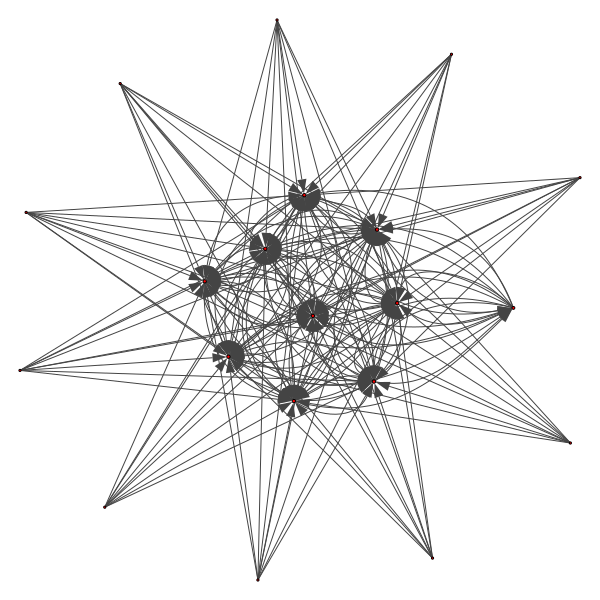

In [10]:
ig.plot(G, vertex_size=np.log(G.vs.degree()))

Decidedly not balanced. The tie break doesn't seem to be randomized....let's check it out.

Under the hood UMAP is using a quicksort on the distances and then a truncation to determine the $k$-nearest neighbours. 

```
def fast_knn_indices(X, n_neighbors):
    """A fast computation of knn indices.
    Parameters
    ----------
    X: array of shape (n_samples, n_features)
        The input data to compute the k-neighbor indices of.
    n_neighbors: int
        The number of nearest neighbors to compute for each sample in ``X``.
    Returns
    -------
    knn_indices: array of shape (n_samples, n_neighbors)
        The indices on the ``n_neighbors`` closest points in the dataset.
    """
    knn_indices = np.empty((X.shape[0], n_neighbors), dtype=np.int32)
    for row in numba.prange(X.shape[0]):
        # v = np.argsort(X[row])  # Need to call argsort this way for numba
        v = X[row].argsort(kind="quicksort")
        v = v[:n_neighbors]
        knn_indices[row] = v
    return knn_indices
```

This is going to give us an overly deterministic choice for the $k$-th neighbour in the case when it is unclear which neighbour is the $k^{th}$ (i.e. there is more than one choice for the $k$-nearest neighbour). 

Let's see what happens downstream.

First, what happens when we symmetrize with fuzzy union?

Degrees: [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 19, 19, 19, 19, 19, 19, 19, 19, 19, 9]


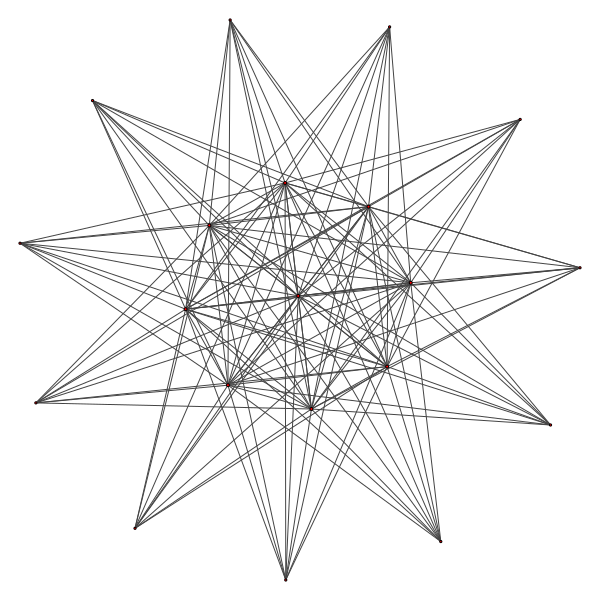

In [11]:
set_op_mix_ratio = 1.0
H = get_VX_from_UX(G.get_adjacency_sparse(), set_op_mix_ratio)
print(f'Degrees: {H.degree()}')
ig.plot(H, vertex_size=np.log(H.vs.degree()))#, target=str(paths['figures_path'] / "20_complete_fuzzy_union_ootb.png"))

And now fuzzy intersection

Degrees: [0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0]


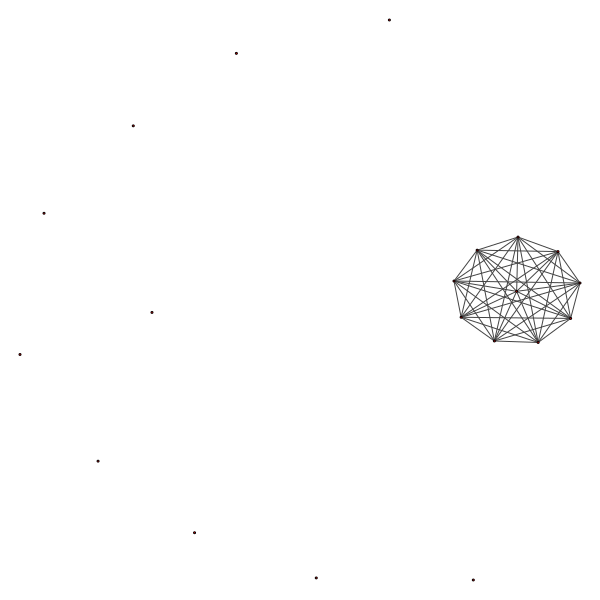

In [12]:
set_op_mix_ratio = 0.0
H = get_VX_from_UX(G.get_adjacency_sparse(), set_op_mix_ratio)
print(f'Degrees: {H.degree()}')
ig.plot(H, vertex_size=2)#, target=str(paths['figures_path'] / "20_complete_fuzzy_intersection_ootb.png"))

In both cases it seems to preserve a single $k$-complete subgraph, and depending on whether it's a union or a intersection, connects or disconnects that subgraph to the other nodes. 



This persists with pretty much any value of $n$ you want to pick. Let's take a look at a larger value of $n$ to check.

In [13]:
n = 20000

In [14]:
M = np.ones((n, n)) - np.identity(n)

In [15]:
G = get_graph_UX(M,
                 n_neighbors=k,
                 random_state=random_state,
                 metric=metric)

In [16]:
np.unique(G.degree(), return_counts=True)

(array([    9,   159,   193,   419,   699,   785,  2965,  3481,  8960,
        10189, 16336, 16439, 19488, 20008]),
 array([19983,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     5]))

Sanity check: Row sums turn out as expected. Each node has $k-1$ outgoing edges.

In [17]:
np.unique(G.outdegree(), return_counts=True)

(array([9]), array([20000]))

Column sums are decidedly unbalanced. There are a few preferencial nodes with extremely high in-degree.

In [18]:
np.unique(G.indegree(), return_counts=True)

(array([    0,   150,   184,   410,   690,   776,  2956,  3472,  8951,
        10180, 16327, 16430, 19479, 19999]),
 array([19983,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     5]))

Let's explore the downstream effects for a moment. 

In [19]:
set_op_mix_ratio = 1.0
H = get_VX_from_UX(G.get_adjacency_sparse(), set_op_mix_ratio)
np.unique(H.degree(), return_counts=True)

(array([    9,   159,   193,   419,   699,   784,  2965,  3473,  8960,
        10180, 16327, 16430, 19479, 19999]),
 array([19983,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     5]))

In [20]:
set_op_mix_ratio = 0.0
H = get_VX_from_UX(G.get_adjacency_sparse(), set_op_mix_ratio)
np.unique(H.degree(), return_counts=True)

(array([0, 1, 8, 9]), array([19989,     1,     1,     9]))

Here's the non-zero degree subgraph, it's an almost $k-1$-complete graph.

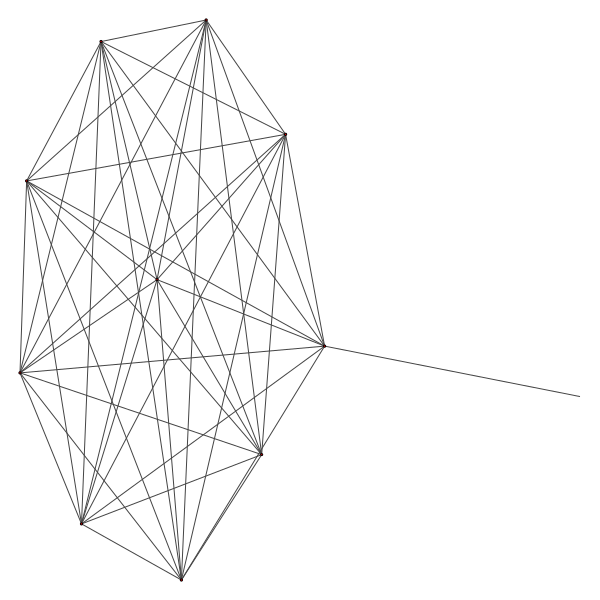

In [21]:
sg = H.subgraph([v for v in H.vs if (v.degree() > 0)])
ig.plot(sg, vertex_size=np.log(sg.vs.degree()))

Assuming fuzzy union, here's the 2D embedding we get:

In [22]:
X_rep = umap.UMAP(n_neighbors=k,
                  random_state=random_state,
                  metric=metric).fit(M)

/Users/amywooding/miniconda3/envs/HighDimensionalClustering/lib/python3.7/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


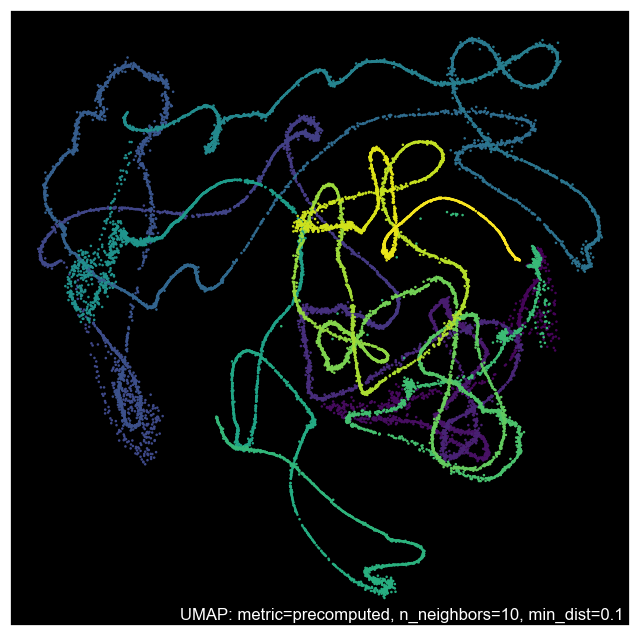

In [23]:
umap_plot = umap.plot.points(X_rep, values=np.arange(n), theme='viridis')
#umap_plot.figure.savefig(paths['figures_path'] / "2000_complete_embedding_ootb.png")

And assuming fuzzy intersection...

(Note: This won't work if you you don't reset init to random, since there are so many disconnected nodes)

In [24]:
X_rep = umap.UMAP(n_neighbors=k,
                  random_state=random_state,
                  set_op_mix_ratio=0.0,
                  metric=metric,
                  init='random',
                 ).fit(M)

/Users/amywooding/miniconda3/envs/HighDimensionalClustering/lib/python3.7/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/Users/amywooding/miniconda3/envs/HighDimensionalClustering/lib/python3.7/site-packages/umap/umap_.py:133: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = inf has removed 0 edges.
It has fully disconnected 19989 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  f"A large number of your vertices were disconnected from the manifold.\n"


In [25]:
Y = X_rep.embedding_

It looks like it has refused to embed the singletons

In [26]:
np.isnan(Y).sum()

39978

And this is what's left:

In [27]:
Z = Y[~np.isnan(Y)]
Z

array([19.331419 ,  5.130353 , 19.337297 ,  5.1309266, 19.336449 ,
        5.130902 , 19.336477 ,  5.130902 , 19.336464 ,  5.1309066,
       19.33648  ,  5.1308985, 19.33647  ,  5.1308994, 19.336445 ,
        5.1309066, 19.33644  ,  5.130904 , 19.336424 ,  5.130909 ,
       19.336414 ,  5.130905 ], dtype=float32)

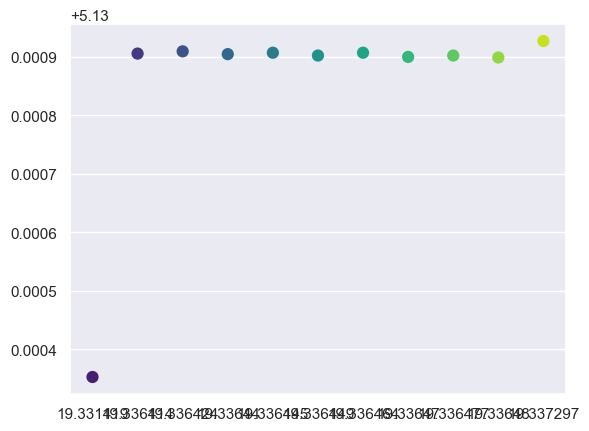

In [28]:
sns.pointplot(x=Z[::2], y=Z[1::2], palette='viridis');

So, it did something strange, but not unexpected. It embedded the the subgraph of nodes that had non-zero degree and it separated off the node of degree 1 from the others.

## Pretend to randomly sample the $k$-nearest neighbours

It seems unfair to expect UMAP to have a non-deterministic tie-break algorithm since it was written to deal with metric spaces (like Euclidean) where you don't expect to have a lot of integral (and hence equal) distances amongst neighbours. Let's add some noise to the distance matrix to sample $k$ of the $n$ neighbours and see if it gives a balanced result then. 

Let's look at the bigger example again, but with noise

In [29]:
n = 20000

In [30]:
M = np.ones((n, n)) - np.identity(n) + ((np.random.rand(n,n)*0.1)-0.05)

In [31]:
G = get_graph_UX(M,
                 n_neighbors=k,
                 random_state=random_state,
                 metric=metric)

Sanity check: Row sums turn out as expected. Each node has $k-1$ outgoing edges.

In [32]:
np.unique(G.outdegree(), return_counts=True)

(array([9]), array([20000]))

Column sums are now more balanced around $k$.

In [33]:
np.unique(G.indegree(), return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 26]),
 array([   2,   17,  107,  287,  617, 1264, 1803, 2391, 2565, 2682, 2503,
        1929, 1387,  996,  600,  390,  223,  123,   56,   31,   18,    3,
           4,    1,    1]))

Let's explore the downstream effects for a moment. 

In [34]:
set_op_mix_ratio = 1.0
H = get_VX_from_UX(G.get_adjacency_sparse(), set_op_mix_ratio)
np.unique(H.degree(), return_counts=True)

(array([ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
        26, 27, 28, 29, 30, 31, 32, 35]),
 array([   2,   17,  107,  290,  617, 1266, 1812, 2388, 2565, 2686, 2505,
        1924, 1389,  989,  594,  391,  222,  122,   56,   31,   18,    3,
           4,    1,    1]))

In [35]:
set_op_mix_ratio = 0.0
H = get_VX_from_UX(G.get_adjacency_sparse(), set_op_mix_ratio)
np.unique(H.degree(), return_counts=True)

(array([0, 1]), array([19884,   116]))

Here's the non-zero degree subgraph.

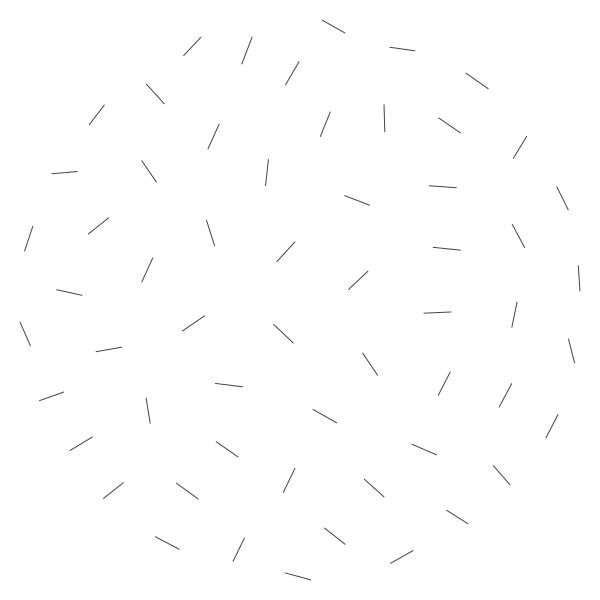

In [36]:
sg = H.subgraph([v for v in H.vs if (v.degree() > 0)])
ig.plot(sg, vertex_size=np.log(sg.vs.degree()))

Assuming fuzzy union, here's the 2D embedding we get:

In [37]:
X_rep = umap.UMAP(n_neighbors=k,
                  random_state=random_state,
                  metric=metric).fit(M)

/Users/amywooding/miniconda3/envs/HighDimensionalClustering/lib/python3.7/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


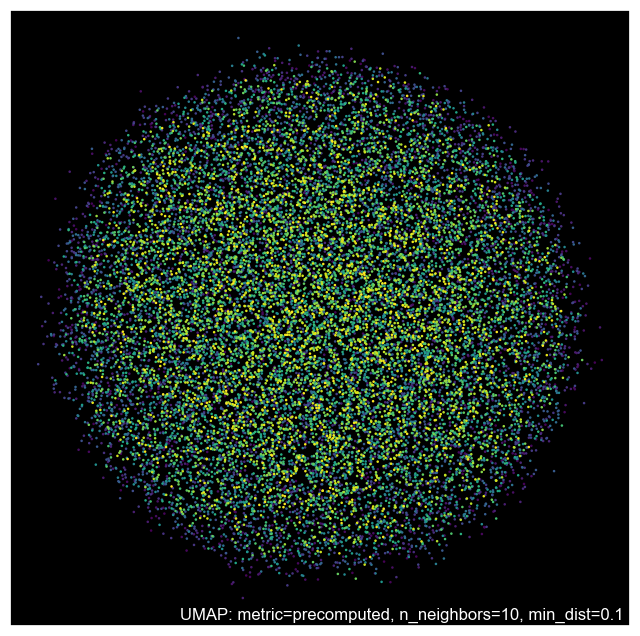

In [38]:
umap_plot = umap.plot.points(X_rep, values=np.arange(n), theme='viridis');
#umap_plot.figure.savefig(paths['figures_path'] / "2000_complete_embedding_random.png")

And assuming fuzzy intersection...

/Users/amywooding/miniconda3/envs/HighDimensionalClustering/lib/python3.7/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/Users/amywooding/miniconda3/envs/HighDimensionalClustering/lib/python3.7/site-packages/umap/umap_.py:133: UserWarning: A large number of your vertices were disconnected from the manifold.
Disconnection_distance = inf has removed 0 edges.
It has fully disconnected 19886 vertices.
You might consider using find_disconnected_points() to find and remove these points from your data.
Use umap.utils.disconnected_vertices() to identify them.
  f"A large number of your vertices were disconnected from the manifold.\n"


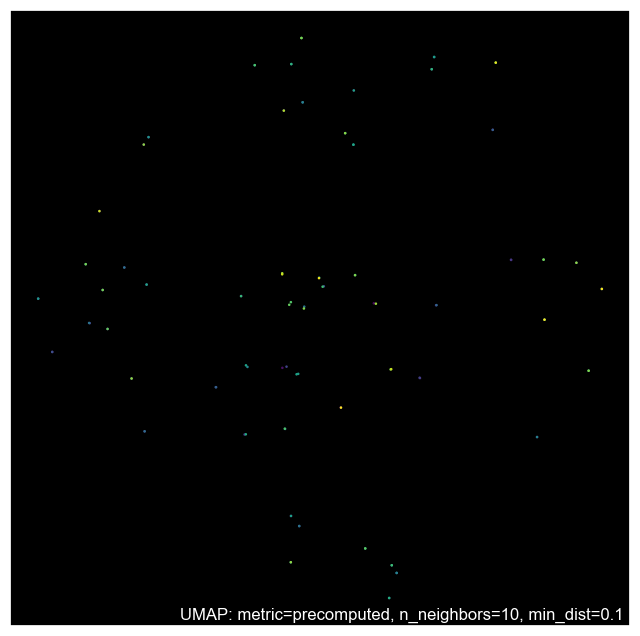

In [39]:
X_rep = umap.UMAP(n_neighbors=k,
                  random_state=random_state,
                  set_op_mix_ratio=0.0,
                  metric=metric,
                  init='random').fit(M)
umap.plot.points(X_rep, values=np.arange(n), theme='viridis');

In [40]:
Y = X_rep.embedding_

Again, the graph layout refused to place the singletons. 

In [41]:
np.isnan(Y).sum()

39772

And this is what's left:

In [42]:
Z = Y[~np.isnan(Y)]
Z

array([ 5.875388  , 11.916631  ,  6.502912  ,  5.507018  ,  5.466565  ,
        2.3719866 ,  3.6399062 ,  3.5645707 ,  3.9096496 , -0.89557576,
       10.223314  , 10.731511  , -3.5622315 ,  4.0428886 , 11.610562  ,
        1.48011   , -0.6996037 , 10.287239  , -2.0851064 ,  8.283478  ,
       -0.67138684,  1.6525121 , 10.798338  ,  6.8128886 , -1.3058907 ,
        6.586352  ,  2.349616  ,  5.727761  ,  7.946289  ,  3.2557607 ,
        8.449939  ,  5.449341  , -0.5482848 , 10.510382  ,  2.4578755 ,
        1.5566202 , 10.795914  ,  6.816864  , -1.8316467 ,  4.735162  ,
        3.6854546 , 11.310952  ,  7.936098  ,  3.266287  ,  3.770095  ,
        3.599882  , -0.610266  ,  6.0710855 , -2.3889735 ,  4.909248  ,
       12.841606  ,  6.728494  , -4.001504  ,  5.6472025 ,  4.937366  ,
        6.018507  , -3.5620277 ,  4.042793  ,  4.1674    , -1.200818  ,
       -1.9836422 ,  5.9080806 ,  1.5665886 ,  2.9810343 , 13.636658  ,
        5.939887  , -1.0816128 ,  3.2425976 ,  1.5557038 ,  2.98

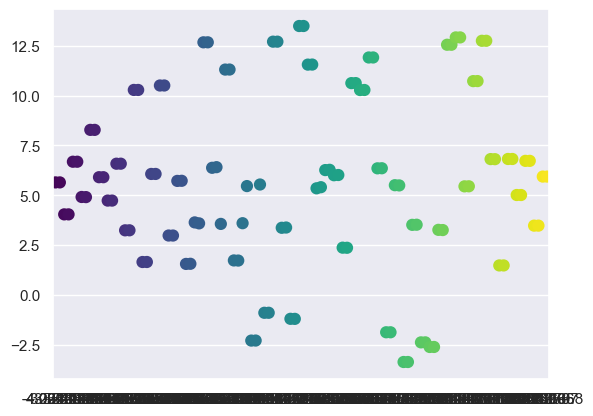

In [43]:
sns.pointplot(x=Z[::2], y=Z[1::2], palette='viridis');

In [44]:
len(Z)

228

This suggests that when messing around with UMAP with objects with integral distances or lots of ties to break when making neighbour sets (e.g. graph distances coming from path lengths), then results will not be as expected and it can be "fixed" with a little bit of noise, effectively randomly sampling the choice of $k$ neighbours if you use fuzzy union. But no matter what you do, fuzzy intersection won't work for this (as implemented at the moment). 

## Explore $k$ relative to $n$

Is $X \rightarrow U(X)$ the identity at $k=n$ neighbours (it should be)?

Note: from now on use noise in the distance matrix to approximate random sampling of $k$ neighbours. 

In [45]:
n = 20

In [46]:
M = np.ones((n, n)) - np.identity(n) 
noise = (np.random.rand(n,n)*0.1)-0.05

In [47]:
G = get_graph_UX(M+noise,
                 n_neighbors=n,
                 random_state=random_state,
                 metric=metric)

In [48]:
np.unique(G.indegree(), return_counts=True)

(array([19]), array([20]))

Is this the identity?

In [49]:
(G.get_adjacency_sparse().toarray() == M).all()

True

Good news. It does what it "should".

Quick test that wasn't an accident:

In [50]:
for n in np.arange(100, 1000, 100):
    M = np.ones((n, n)) - np.identity(n) 
    noise = (np.random.rand(n,n)*0.1)-0.05
    G = get_graph_UX(M+noise,
                 n_neighbors=n,
                 random_state=random_state,
                 metric=metric)
    if not (G.get_adjacency_sparse().toarray() == M).all():
        print(n)

What about with random distances? What happens if we throw out the equidistant assumption and assume that we have a complete graph with random distances (weights on the edges) from [0, 1)? 

In [51]:
for n in np.arange(100, 1001, 100):
    M = np.ones((n, n)) - np.identity(n) 
    A = np.random.rand(n, n)
    G = get_graph_UX(A,
                 n_neighbors=n,
                 random_state=random_state,
                 metric=metric)
    difference = int((M - G.get_adjacency_sparse().toarray()).sum())
    if not (difference == 0):
        n_rows = (G.get_adjacency_sparse().toarray().sum(axis=1) < (n-1)).sum()
        print(f'n: {n}, total difference: {difference}, nodes with less neighbours:{n_rows}, large distances:{(A > 0.9998).sum()}')

n: 400, total difference: 177, nodes with less neighbours:2, large distances:33
n: 500, total difference: 424, nodes with less neighbours:7, large distances:40
n: 600, total difference: 1294, nodes with less neighbours:21, large distances:76
n: 700, total difference: 4377, nodes with less neighbours:51, large distances:104
n: 800, total difference: 14824, nodes with less neighbours:143, large distances:109
n: 900, total difference: 30575, nodes with less neighbours:253, large distances:167
n: 1000, total difference: 58842, nodes with less neighbours:402, large distances:169


This seems to stop giving the the full number of requested neighbours when it gets to around 400-500 neighbours. 

There are a bunch of nodes with less than $n-1$ neighbours. This could make sense, as there are now more potentially "far" neighbours, so some of the weights must be going to zero? Need to check on this. 

In [52]:
np.unique(G.outdegree(), return_counts=True)

(array([397, 447, 487, 494, 509, 523, 530, 575, 576, 597, 617, 626, 627,
        641, 644, 649, 654, 655, 656, 657, 659, 670, 673, 674, 677, 679,
        681, 685, 687, 691, 694, 695, 697, 698, 700, 703, 710, 717, 718,
        721, 722, 724, 729, 730, 731, 733, 737, 739, 740, 742, 743, 744,
        745, 746, 749, 750, 751, 755, 756, 757, 758, 759, 760, 762, 763,
        765, 766, 767, 768, 770, 771, 772, 773, 774, 775, 776, 778, 781,
        785, 786, 787, 790, 791, 793, 795, 796, 798, 799, 803, 804, 805,
        806, 807, 808, 810, 811, 812, 814, 815, 817, 818, 820, 821, 822,
        823, 824, 825, 826, 827, 828, 829, 830, 831, 833, 834, 835, 836,
        837, 839, 841, 842, 843, 844, 845, 847, 848, 849, 850, 851, 853,
        854, 856, 857, 858, 859, 860, 863, 864, 867, 868, 869, 872, 874,
        875, 876, 877, 879, 880, 881, 883, 884, 886, 887, 889, 890, 891,
        893, 895, 896, 897, 898, 899, 900, 901, 903, 904, 905, 906, 907,
        908, 909, 910, 911, 912, 913, 915, 916, 917

# Another thing I don't understand

By doing something really degenerate (making my distance to myself 1), I can get more neighbours than I should...trying to figure out why. 

In [53]:
k = 10
n = 200
M = np.ones((n, n)) #- np.identity(n) 
G = get_graph_UX(M,
             n_neighbors=k, 
             random_state=random_state,
             metric=metric)

In [54]:
np.unique(G.outdegree(), return_counts=True)

(array([ 9, 10]), array([ 10, 190]))